In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load test module for sanity check
from test_utils import test

Data Generation
===

In [ ]:
np.random.seed(10)
P, Q = (np.random.rand(i, 2) for i in (4, 5))
P_big, Q_big = (np.random.rand(i, 80) for i in (100, 120))

print(P, "\n\n", Q)

[[0.77132064 0.02075195]
 [0.63364823 0.74880388]
 [0.49850701 0.22479665]
 [0.19806286 0.76053071]] 

 [[0.16911084 0.08833981]
 [0.68535982 0.95339335]
 [0.00394827 0.51219226]
 [0.81262096 0.61252607]
 [0.72175532 0.29187607]]


Solution
===

In [ ]:
def naive(P, Q):
    """
    A naive solution for finding pairvise distances between poins in P and Q
    
    Args:
        P: numpy array of shape=(p, 2)
        Q: numpy array of shape=(q, 2)
    Returns:
        D: numpy array of shape=(p*q,)
        
    >>> naive(np.array([[0, 1]]), np.array([[2, 3], [4, 5]]))
    array([[2.82842712, 5.65685425]])
    """

    p, q = P.shape[0], Q.shape[0]
    result = np.empty(p*q)
    for i in range(p):
        for j in range(q):
            p1, p2 = P[i], Q[j]
            d = np.sqrt(np.sum((p1 - p2)**2))
            result[i*j + j] = d
    
    return result.reshape(1, -1)
test(naive)

✅ Your `naive` passed 1 tests.


### Use matching indices

Instead of iterating through indices, one can use them directly to parallelize the operations with Numpy.

In [ ]:
rows, cols = np.indices((P.shape[0], Q.shape[0]))
print(rows, end="\n\n")
print(cols)

[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]]

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]


In [ ]:
print(P[rows.ravel()], end="\n\n")
print(Q[cols.ravel()])

[[0.77132064 0.02075195]
 [0.77132064 0.02075195]
 [0.77132064 0.02075195]
 [0.77132064 0.02075195]
 [0.77132064 0.02075195]
 [0.63364823 0.74880388]
 [0.63364823 0.74880388]
 [0.63364823 0.74880388]
 [0.63364823 0.74880388]
 [0.63364823 0.74880388]
 [0.49850701 0.22479665]
 [0.49850701 0.22479665]
 [0.49850701 0.22479665]
 [0.49850701 0.22479665]
 [0.49850701 0.22479665]
 [0.19806286 0.76053071]
 [0.19806286 0.76053071]
 [0.19806286 0.76053071]
 [0.19806286 0.76053071]
 [0.19806286 0.76053071]]

[[0.16911084 0.08833981]
 [0.68535982 0.95339335]
 [0.00394827 0.51219226]
 [0.81262096 0.61252607]
 [0.72175532 0.29187607]
 [0.16911084 0.08833981]
 [0.68535982 0.95339335]
 [0.00394827 0.51219226]
 [0.81262096 0.61252607]
 [0.72175532 0.29187607]
 [0.16911084 0.08833981]
 [0.68535982 0.95339335]
 [0.00394827 0.51219226]
 [0.81262096 0.61252607]
 [0.72175532 0.29187607]
 [0.16911084 0.08833981]
 [0.68535982 0.95339335]
 [0.00394827 0.51219226]
 [0.81262096 0.61252607]
 [0.72175532 0.29187607

In [ ]:
def with_indices(P, Q):
    """
    An optimized solution using matching indices
    
    Args:
        P: numpy array of shape=(p, 2)
        Q: numpy array of shape=(q, 2)
    Returns:
        D: numpy array of shape=(p*q,)
        
    >>> with_indices(np.array([[0, 1]]), np.array([[2, 3], [4, 5]]))
    array([[2.82842712, 5.65685425]])
    """

    rows, cols = np.indices((P.shape[0], Q.shape[0]))
    cdiff = P[rows.ravel()]  - Q[cols.ravel()]
    result = np.sqrt(np.sum(((cdiff)**2), axis=1))
    return result.reshape(1, -1)

    
test(with_indices)

✅ Your `with_indices` passed 1 tests.


### Use a library

`scipy` is the equivalent of matlab toolboxes and have a lot to offer. Actually the pairwise computation is part of the library through the `spatial` module.

In [ ]:
from scipy.spatial.distance import cdist


def scipy_version(P, Q):
    return cdist(P, Q)

### Numpy Magic

In [ ]:
def tensor_broadcasting(P, Q):
    return np.sqrt(np.sum((P[:, np.newaxis, :] - Q[np.newaxis, :, :]) ** 2, axis=2))

# Compare methods

In [ ]:
methods = [
    naive,
    with_indices,
    scipy_version,
    tensor_broadcasting,
]
timers = []
for f in methods:
    r = %timeit -o f(P_big, Q_big)
    timers.append(r)

72.5 ms ± 5.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.58 ms ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
344 µs ± 2.53 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.3 ms ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


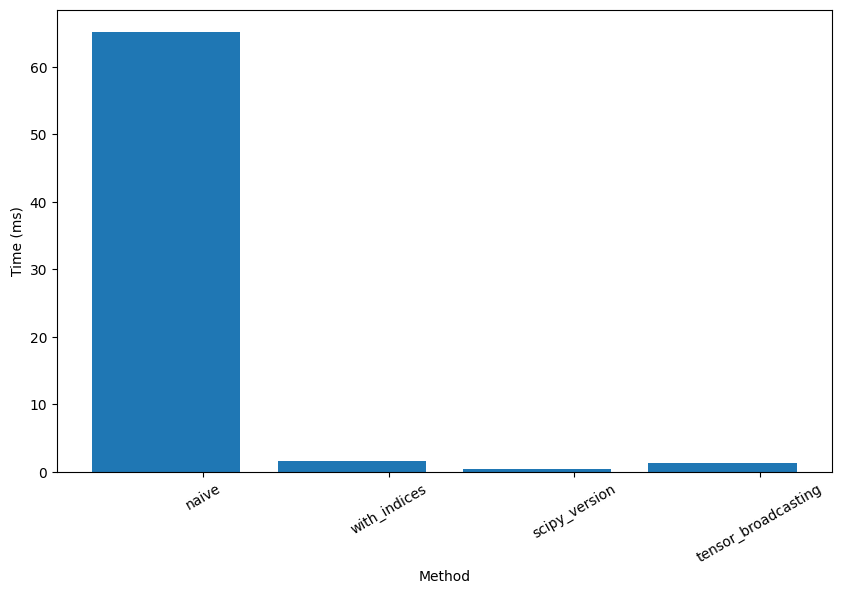

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(
    np.arange(len(methods)), [r.best * 1000 for r in timers], log=False
)  # Set log to True for logarithmic scale
plt.xticks(np.arange(len(methods)) + 0.2, [f.__name__ for f in methods], rotation=30)
plt.xlabel("Method")
plt.ylabel("Time (ms)")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bd8d100d-91c1-4a16-80ec-ad449ef32ce3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>